In [67]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import model_functions as mf
import feature_eng as fe
import importlib
importlib.reload(mf)
importlib.reload(fe)

<module 'feature_eng' from '/Users/yorkmacbook020/Documents/york/jenny-huang/jenny-huang-aml-student-regression/feature_eng.py'>

In [40]:
#load features + targets
X = fe.X
y = fe.y
X_train, X_test, y_train, y_test = fe.split_transform(X, y, fe.ord_trans)

In [41]:
#models and selectors 
models = [SVR(), RandomForestRegressor(), Ridge(), KNeighborsRegressor(), GradientBoostingRegressor()]
selectors = [SelectKBest(k = i, score_func = mutual_info_regression) for i in range (3, len(X_train.columns)+1)]

In [42]:
#demonstrate how test_features works
rf_features = mf.test_features(RandomForestRegressor(), X_train, X_test, y_train, y_test, selectors)
rf_features['n'] = [len(l) for l in rf_features['features']]
rf_features.head()

,selector,features,r2,mse,mae,relative error,n
0,"SelectKBest(k=3, score_func=<function mutual_i...","[G1, G2, Gavg]",0.712511,6.115789,1.463158,0.131754,3
1,"SelectKBest(k=4, score_func=<function mutual_i...","[absences, G1, G2, Gavg]",0.791187,4.442105,1.052632,0.094787,4
2,"SelectKBest(k=5, score_func=<function mutual_i...","[address, absences, G1, G2, Gavg]",0.804547,4.157895,1.000000,0.090047,5
3,"SelectKBest(k=6, score_func=<function mutual_i...","[Medu, Walc, absences, G1, G2, Gavg]",0.812959,3.978947,1.031579,0.092891,6
4,"SelectKBest(k=7, score_func=<function mutual_i...","[Mjob, failures, romantic, absences, G1, G2, G...",0.822361,3.778947,1.084211,0.097630,7


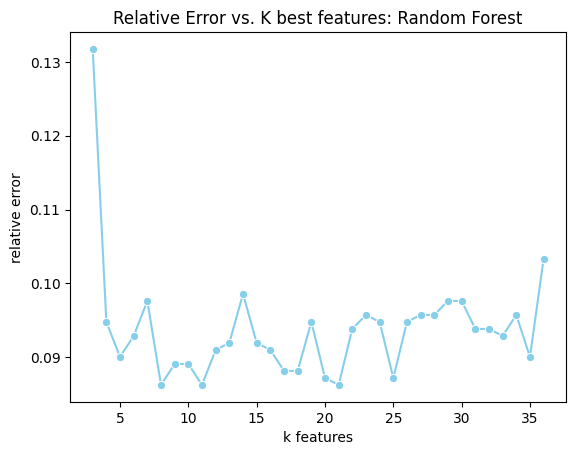

In [43]:
#visualize performance vs features
sns.lineplot(x=rf_features['n'], y=rf_features['relative error'], marker='o', color = 'skyblue')
plt.xlabel ('k features')
plt.title('Relative Error vs. K best features: Random Forest')
plt.savefig('figures/kfeatures.png', dpi = 300, bbox_inches='tight')

In [44]:
best_features = mf.compare_models(models, X_train, X_test, y_train, y_test, selectors, 'relative error')


In [45]:
best_features.head(6)

,model,k features,features,r2,mse,mae,relative error
0,RandomForestRegressor(),14,"[Mjob, Fjob, Medu, studytime, failures, famsup...",0.876790,2.621053,0.915789,0.082464
1,KNeighborsRegressor(),6,"[Mjob, paid, absences, G1, G2, Gavg]",0.888666,2.368421,1.021053,0.091943
2,GradientBoostingRegressor(),21,"[Mjob, guardian, sex, address, Pstatus, Medu, ...",0.814443,3.947368,1.021053,0.091943
3,SVR(),4,"[absences, G1, G2, Gavg]",0.795146,4.357895,1.178947,0.106161
4,Ridge(),3,"[G1, G2, Gavg]",0.811969,4.000000,1.200000,0.108057


In [46]:
#visualizing feature and model type performance
best_features['summary'] = [f"{best_features.iloc[i]['model']}\n{best_features.iloc[i]['k features']} features" for i in best_features.index]

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_48511/1563172018.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = best_features['summary'], x= best_features['relative error'], palette = sns.color_palette("husl", 6))
/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_48511/1563172018.py:1: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(y = best_features['summary'], x= best_features['relative error'], palette = sns.color_palette("husl", 6))


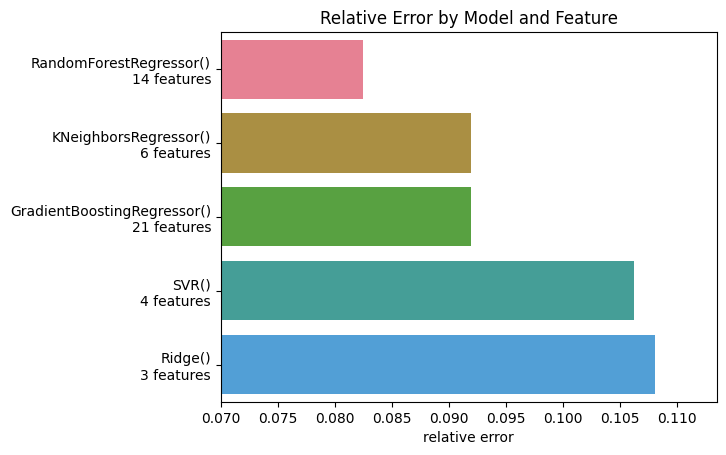

In [47]:
sns.barplot(y = best_features['summary'], x= best_features['relative error'], palette = sns.color_palette("husl", 6))
plt.xlim(0.07)
plt.ylabel('')
plt.title("Relative Error by Model and Feature")
plt.savefig('figures/relative_e_feature_selection.png', dpi = 300, bbox_inches='tight')

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_48511/2269840001.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = best_features['summary'], x= best_features['r2'], palette = sns.color_palette("husl", 6))
/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_48511/2269840001.py:1: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(y = best_features['summary'], x= best_features['r2'], palette = sns.color_palette("husl", 6))


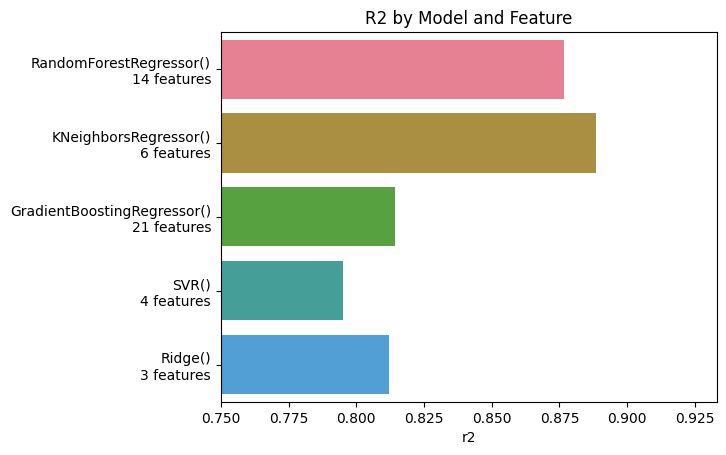

In [48]:
sns.barplot(y = best_features['summary'], x= best_features['r2'], palette = sns.color_palette("husl", 6))
plt.xlim(0.75)
plt.ylabel('')
plt.title("R2 by Model and Feature")
plt.savefig('figures/r2_feature_selection.png', dpi = 300, bbox_inches='tight')

In [49]:
#hyperparameters to test
params = {"SVR()": {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], #SVR
          'gamma' : [10**x/10000 for x in range (3)],
          'C' : [10**x/100 for x in range (0,3)]},
          "SGDRegressor()": {'loss' : ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],   #SGD
           'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']   
          },
          "RandomForestRegressor()": {'n_estimators' : range(10, 160, 10),     #Random Forest
           'max_features' : ['sqrt', 'log2', None]
          },
          "Ridge()": {'alpha' : [10**x/100000 for x in range(0, 10,2)]  #Ridge
          },
          "KNeighborsRegressor()": {'n_neighbors' : range(2,21),     #KNeighbors
           'weights'  : ['uniform', 'distance']     
          },
          "GradientBoostingRegressor()": {
            'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],  #Gradient Boosting
            'n_estimators' : range(10, 160, 10)
          }
}

In [50]:
#tune hyperparameters for the top 3 models
stats = {}
for i in (best_features.index[:3]): 
    model = eval(best_features.iloc[i]['model'])
    features = best_features.iloc[i]['features']
    hps = params[best_features.iloc[i]['model']]
    results = mf.tune_model(model, X_train[features], y_train, hps)
    print(f"doing {model}")
    stats[(str(model), str(features))] = results

doing RandomForestRegressor()
doing KNeighborsRegressor()
doing GradientBoostingRegressor()


In [51]:
# #get parameters into individual columns so i can do visualizations. extremely inefficient lol 
# fig, ax = plt.subplots(1,3, figsize =(20,20))
# for k, v in stats.items():
#     v[['param1', 'param2']] = v['params'].apply(pd.Series)
#     v = v.rename(columns= {'param1' : list(v.iloc[0]['params'].keys())[0], 'param2' : list(v.iloc[0]['params'].keys())[1]})
#     v = v.iloc[:,:-2]
#     temp = v.drop('params', axis = 1)
#     temp.pivot(index = temp.columns[-1], columns = temp.columns[-2], values = 'mean_test_score')
#     sns.heatmap(temp, ax = ax[0,1])

In [52]:
#apply tuned hyperparameters 
tuned_stats = pd.DataFrame(columns = ['model', 'params','n','features', 'r2', 'mse', 'mae', 'relative error'])
for k,v in stats.items():
    params = v['params'][0]
    features = eval(k[1])
    model = eval(k[0][:-2])(**params)
    model.fit(X_train[features], y_train)
    pred = model.predict(X_test[features])
    r2 = r2_score(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    percent_e = mae/y_test.mean()
    tuned_stats.loc[len(tuned_stats.index)] = [k[0], params, len(features), features, r2, mse, mae, percent_e]

In [53]:
tuned_stats['summary'] = [f"{tuned_stats.iloc[i]['model']}:\n{tuned_stats.iloc[i]['params']}\n features: {tuned_stats.iloc[i]['features'] if len(tuned_stats.iloc[i]['features'])<10 else len(tuned_stats.iloc[i]['features'])}" for i in tuned_stats.index]

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_48511/3831661587.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= tuned_stats['summary'], x = tuned_stats['relative error'], palette = sns.color_palette('husl',3))


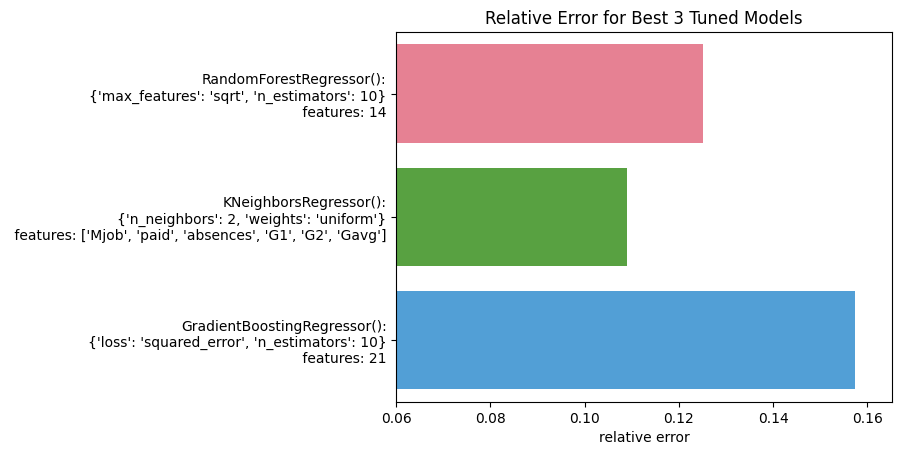

In [54]:
#relative error for tuned models 
sns.barplot(y= tuned_stats['summary'], x = tuned_stats['relative error'], palette = sns.color_palette('husl',3))
plt.ylabel('')
plt.xlim(0.06)
plt.title("Relative Error for Best 3 Tuned Models")
plt.savefig('figures/relative_e_tuned.png', dpi = 300, bbox_inches='tight')

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_48511/2031736280.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= tuned_stats['summary'], x = tuned_stats['r2'], palette = sns.color_palette('husl',3))


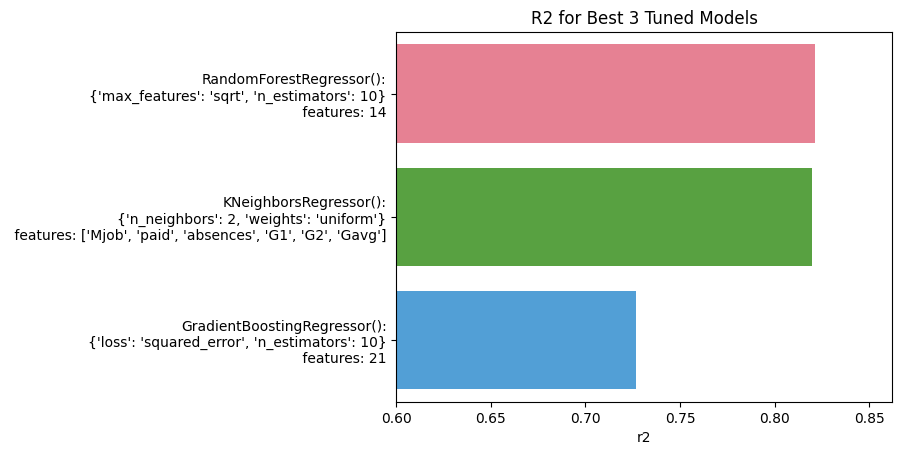

In [55]:
#r2 for best tuned models
sns.barplot(y= tuned_stats['summary'], x = tuned_stats['r2'], palette = sns.color_palette('husl',3))
plt.ylabel('')
plt.xlim(0.6)
plt.title("R2 for Best 3 Tuned Models")
plt.savefig('figures/r2_tuned.png', dpi = 300, bbox_inches='tight')

In [65]:
tuned_stats.head(6)

,model,params,n,features,r2,mse,mae,relative error,summary
0,RandomForestRegressor(),"{'max_features': 'sqrt', 'n_estimators': 10}",14,"[Mjob, Fjob, Medu, studytime, failures, famsup...",0.821029,3.807263,1.388421,0.125024,RandomForestRegressor():\n{'max_features': 'sq...
1,KNeighborsRegressor(),"{'n_neighbors': 2, 'weights': 'uniform'}",6,"[Mjob, paid, absences, G1, G2, Gavg]",0.819886,3.831579,1.210526,0.109005,"KNeighborsRegressor():\n{'n_neighbors': 2, 'we..."
2,GradientBoostingRegressor(),"{'loss': 'squared_error', 'n_estimators': 10}",21,"[Mjob, guardian, sex, address, Pstatus, Medu, ...",0.726600,5.816071,1.748121,0.157414,GradientBoostingRegressor():\n{'loss': 'square...


In [57]:
#testing encoding methods 
X_train_oh, X_test_oh, y_train_oh, y_test_oh = fe.split_transform(X, y, fe.ohe_trans)
selectors_ohe = [SelectKBest(k = i, score_func = mutual_info_regression) for i in range (3, len(X_train_oh.columns)+1)]
best_features_ohe = mf.compare_models(models, X_train_oh, X_test_oh, y_train, y_test, selectors_ohe, 'relative error')

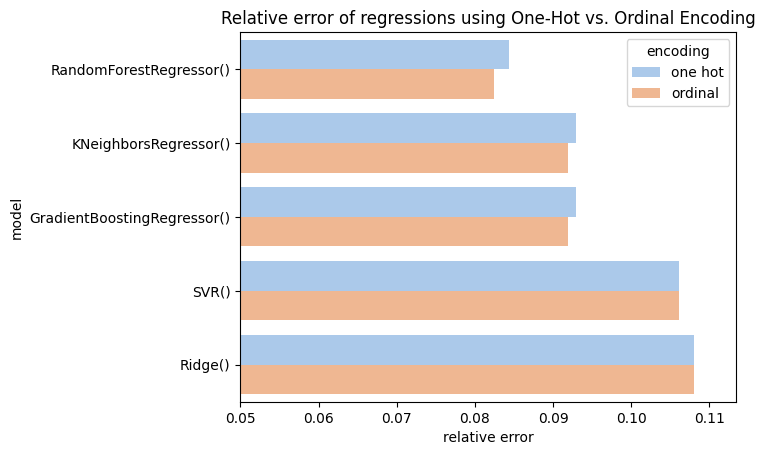

In [58]:
compare = pd.concat([best_features_ohe[['model', 'relative error']], best_features[['model', 'relative error']]], axis = 0).reset_index(drop = True)
compare['encoding'] =["one hot" if i <5 else "ordinal" for i in compare.index]
sns.barplot(compare, y = 'model', x= 'relative error', hue = 'encoding', palette = 'pastel', orient = 'h')
plt.xlim(0.05)
plt.title("Relative error of regressions using One-Hot vs. Ordinal Encoding")
plt.savefig('figures/comparing_encoding.png', bbox_inches='tight')

In [68]:
#Using best model, look at which values are most difficult to predict 
final = KNeighborsRegressor(n_neighbors=2, weights = 'uniform')
features = ['absences', 'G1', 'G2', 'Gavg', 'social']	

final.fit(X_train[features], y_train)
pred = np.round(final.predict(X_test[features]))

errors = [abs(pred[i]-list(y_test)[i]) for i in range(len(pred))]
df = pd.DataFrame()
df['true'] = y_test
df['error'] = errors

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_48511/168934399.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x = 'true', y = 'error', palette= sns.color_palette('bright', 20))
/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_48511/168934399.py:1: UserWarning: The palette list has more values (20) than needed (14), which may not be intended.
  sns.boxplot(data = df, x = 'true', y = 'error', palette= sns.color_palette('bright', 20))


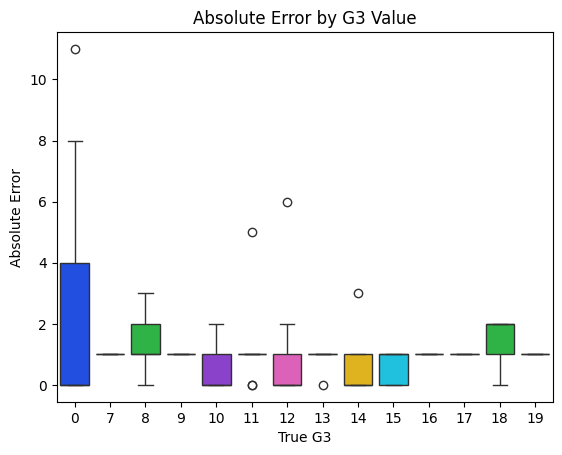

In [72]:

sns.boxplot(data = df, x = 'true', y = 'error', palette= sns.color_palette('bright', 20))
plt.title("Absolute Error by G3 Value")
plt.xlabel('True G3')
plt.ylabel("Absolute Error")
plt.savefig('figures/error_vs_true.png', bbox_inches="tight")

In [70]:
df.groupby('true').agg({'error' : 'mean'})

,error
true,
0,2.555556
7,1.000000
8,1.333333
9,1.000000
10,0.500000
11,1.200000
12,1.000000
13,0.888889
14,0.714286


In [71]:
df['error'].mean()

1.063157894736842